# Board Game Rating Prediction

The dataset was obtained [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2022/2022-01-25/readme.md) with the original source coming from [Kaggle](https://www.kaggle.com/datasets/jvanelteren/boardgamegeek-reviews?select=2022-01-08.csv). The data was collected from [BoardGameGeek](https://boardgamegeek.com/).<br><br>
The dataset contains two files: one for information on the games related information and ratings from the website, and the other for information relating to the game and its descriptions. Our goal for this project is to create a machine learning model using information related to these board games that will predict on the target `average`: the average rating of a game.

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.model_selection import train_test_split

alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## Reading in and cleaning the data

In [2]:
# drop everything in rating except id and average
ratings_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-25/ratings.csv"
details_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-25/details.csv"
ratings = pd.read_csv(ratings_url)
details = pd.read_csv(details_url)

In [3]:
ratings.head()

,num,id,name,year,rank,average,bayes_average,users_rated,url,thumbnail
0,105,30549,Pandemic,2008,106,7.59,7.487,108975,/boardgame/30549/pandemic,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...
1,189,822,Carcassonne,2000,190,7.42,7.309,108738,/boardgame/822/carcassonne,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...
2,428,13,Catan,1995,429,7.14,6.970,108024,/boardgame/13/catan,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...
3,72,68448,7 Wonders,2010,73,7.74,7.634,89982,/boardgame/68448/7-wonders,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...
4,103,36218,Dominion,2008,104,7.61,7.499,81561,/boardgame/36218/dominion,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...


In [4]:
details.head()

,num,id,primary,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,...,boardgamefamily,boardgameexpansion,boardgameimplementation,boardgamedesigner,boardgameartist,boardgamepublisher,owned,trading,wanting,wishing
0,0,30549,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,45,...,"['Components: Map (Global Scale)', 'Components...",['Pandemic: Gen Con 2016 Promos – Z-Force Team...,"['Pandemic Legacy: Season 0', 'Pandemic Legacy...",['Matt Leacock'],"['Josh Cappel', 'Christian Hanisch', 'Régis Mo...","['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It...",168364,2508,625,9344
1,1,822,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,45,30,45,...,"['Cities: Carcassonne (France)', 'Components: ...","['20 Jahre Darmstadt Spielt', 'Apothecaries (f...","['The Ark of the Covenant', 'Carcassonne für 2...",['Klaus-Jürgen Wrede'],"['Doris Matthäus', 'Anne Pätzke', 'Chris Quill...","['Hans im Glück', '999 Games', 'Albi', 'Bard C...",161299,1716,582,7383
2,2,13,Catan,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,120,60,120,...,"['Animals: Sheep', 'Components: Hexagonal Tile...","['20 Jahre Darmstadt Spielt', 'Brettspiel Adve...","['Baden-Württemberg Catan', 'Catan Geographies...",['Klaus Teuber'],"['Volkan Baga', 'Tanja Donner', 'Pete Fenlon',...","['KOSMOS', '999 Games', 'Albi', 'Asmodee', 'As...",167733,2018,485,5890
3,3,68448,7 Wonders,You are the leader of one of the 7 great citie...,2010,2,7,30,30,30,...,"['Ancient: Babylon', 'Ancient: Egypt', 'Ancien...","['7 Wonders: Armada', '7 Wonders: Babel', '7 W...","['7 Wonders (Second Edition)', '7 Wonders Duel...",['Antoine Bauza'],"['Dimitri Chappuis', 'Miguel Coimbra', 'Etienn...","['Repos Production', 'ADC Blackfire Entertainm...",120466,1567,1010,12105
4,4,36218,Dominion,"&quot;You are a monarch, like your parents bef...",2008,2,4,30,30,30,...,"['Crowdfunding: Wspieram', 'Game: Dominion', '...","['Ancient Times (fan expansion for Dominion)',...","['Dominion (Second Edition)', 'Het Koninkrijk ...",['Donald X. Vaccarino'],"['Matthias Catrein', 'Julien Delval', 'Tomasz ...","['Rio Grande Games', '999 Games', 'Albi', 'Bar...",106956,2009,655,8621


Since we do not need all the features, we will remove the ones that we will not use in the prediction task. From `ratings`, we remove everything except `id` and `average`, since we will need `id` to join the two dataframes and `average` is our target column. From details, we remove `num`, `primary`, `owned`, `trading`, `wanting`, and `wishing`. After dropping the columns, we will join the two dataframes on the `id` column.

In [5]:
ratings = ratings[["id", "average"]]
details = details.drop(columns=["num", "primary", "owned", "trading", "wanting", "wishing"])

In [6]:
boardgame_df = details.merge(ratings, on="id", how="left").drop(columns=["id"])
boardgame_df.head()

,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic,boardgamefamily,boardgameexpansion,boardgameimplementation,boardgamedesigner,boardgameartist,boardgamepublisher,average
0,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,45,8,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...",['Pandemic: Gen Con 2016 Promos – Z-Force Team...,"['Pandemic Legacy: Season 0', 'Pandemic Legacy...",['Matt Leacock'],"['Josh Cappel', 'Christian Hanisch', 'Régis Mo...","['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It...",7.59
1,Carcassonne is a tile-placement game in which ...,2000,2,5,45,30,45,7,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...","['Cities: Carcassonne (France)', 'Components: ...","['20 Jahre Darmstadt Spielt', 'Apothecaries (f...","['The Ark of the Covenant', 'Carcassonne für 2...",['Klaus-Jürgen Wrede'],"['Doris Matthäus', 'Anne Pätzke', 'Chris Quill...","['Hans im Glück', '999 Games', 'Albi', 'Bard C...",7.42
2,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,120,60,120,10,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...","['Animals: Sheep', 'Components: Hexagonal Tile...","['20 Jahre Darmstadt Spielt', 'Brettspiel Adve...","['Baden-Württemberg Catan', 'Catan Geographies...",['Klaus Teuber'],"['Volkan Baga', 'Tanja Donner', 'Pete Fenlon',...","['KOSMOS', '999 Games', 'Albi', 'Asmodee', 'As...",7.14
3,You are the leader of one of the 7 great citie...,2010,2,7,30,30,30,10,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Drafting', 'Hand Management', 'Set Collectio...","['Ancient: Babylon', 'Ancient: Egypt', 'Ancien...","['7 Wonders: Armada', '7 Wonders: Babel', '7 W...","['7 Wonders (Second Edition)', '7 Wonders Duel...",['Antoine Bauza'],"['Dimitri Chappuis', 'Miguel Coimbra', 'Etienn...","['Repos Production', 'ADC Blackfire Entertainm...",7.74
4,"&quot;You are a monarch, like your parents bef...",2008,2,4,30,30,30,13,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...","['Crowdfunding: Wspieram', 'Game: Dominion', '...","['Ancient Times (fan expansion for Dominion)',...","['Dominion (Second Edition)', 'Het Koninkrijk ...",['Donald X. Vaccarino'],"['Matthias Catrein', 'Julien Delval', 'Tomasz ...","['Rio Grande Games', '999 Games', 'Albi', 'Bar...",7.61


## Exploratory Data Analysis

In [7]:
boardgame_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21631 entries, 0 to 21630
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   description              21630 non-null  object 
 1   yearpublished            21631 non-null  int64  
 2   minplayers               21631 non-null  int64  
 3   maxplayers               21631 non-null  int64  
 4   playingtime              21631 non-null  int64  
 5   minplaytime              21631 non-null  int64  
 6   maxplaytime              21631 non-null  int64  
 7   minage                   21631 non-null  int64  
 8   boardgamecategory        21348 non-null  object 
 9   boardgamemechanic        20041 non-null  object 
 10  boardgamefamily          17870 non-null  object 
 11  boardgameexpansion       5506 non-null   object 
 12  boardgameimplementation  4862 non-null   object 
 13  boardgamedesigner        21035 non-null  object 
 14  boardgameartist       

Seeing that there are many missing values for `boardgameexpansion` and `boardgameimplementation`, we will drop those columns. Since the columns `description`, `boardgamefamily`, `boardgameartist`, and `boardgamepublisher` also have some missing values in each column, we will drop the rows that contain missing values for those columns. This will also help reduce the overall size of the dataset so it is easier to work with.

In [8]:
boardgame_df = boardgame_df.drop(columns=["boardgameexpansion", "boardgameimplementation"])
boardgame_df = boardgame_df.dropna(subset=["description", "boardgamefamily", "boardgameartist", "boardgamepublisher"])
boardgame_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13220 entries, 0 to 21630
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   description         13220 non-null  object 
 1   yearpublished       13220 non-null  int64  
 2   minplayers          13220 non-null  int64  
 3   maxplayers          13220 non-null  int64  
 4   playingtime         13220 non-null  int64  
 5   minplaytime         13220 non-null  int64  
 6   maxplaytime         13220 non-null  int64  
 7   minage              13220 non-null  int64  
 8   boardgamecategory   13070 non-null  object 
 9   boardgamemechanic   12675 non-null  object 
 10  boardgamefamily     13220 non-null  object 
 11  boardgamedesigner   13144 non-null  object 
 12  boardgameartist     13220 non-null  object 
 13  boardgamepublisher  13220 non-null  object 
 14  average             13220 non-null  float64
dtypes: float64(1), int64(7), object(7)
memory usage: 1.6+

After clearning up the dataset, we can now split the dataset into a training and testing portion and perform EDA.

In [9]:
train_df, test_df = train_test_split(boardgame_df, test_size=0.4, random_state=42)

<br>

**Figure 1: table showing non-missing values and types of each column.**

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7932 entries, 1419 to 9727
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   description         7932 non-null   object 
 1   yearpublished       7932 non-null   int64  
 2   minplayers          7932 non-null   int64  
 3   maxplayers          7932 non-null   int64  
 4   playingtime         7932 non-null   int64  
 5   minplaytime         7932 non-null   int64  
 6   maxplaytime         7932 non-null   int64  
 7   minage              7932 non-null   int64  
 8   boardgamecategory   7839 non-null   object 
 9   boardgamemechanic   7609 non-null   object 
 10  boardgamefamily     7932 non-null   object 
 11  boardgamedesigner   7889 non-null   object 
 12  boardgameartist     7932 non-null   object 
 13  boardgamepublisher  7932 non-null   object 
 14  average             7932 non-null   float64
dtypes: float64(1), int64(7), object(7)
memory usage: 991

**Figure 2: Information about distribution of features.**

In [11]:
train_df.describe(include="all")

,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgameartist,boardgamepublisher,average
count,7932,7932.000000,7932.000000,7932.000000,7932.000000,7932.000000,7932.000000,7932.000000,7839,7609,7932,7889,7932,7932,7932.000000
unique,7925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3288,4211,5694,4343,5081,4844,NaN
top,How could that have happened? Black Stories ar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['Wargame', 'World War II']",['Hexagon Grid'],['Crowdfunding: Kickstarter'],['(Uncredited)'],['(Uncredited)'],['GMT Games'],NaN
freq,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,383,158,336,150,144,123,NaN
mean,NaN,1998.834972,1.931795,4.953858,112.756808,74.986889,112.756808,9.887292,NaN,NaN,NaN,NaN,NaN,NaN,6.634831
std,NaN,141.239955,0.669988,8.179668,784.911114,713.317400,784.911114,3.516219,NaN,NaN,NaN,NaN,NaN,NaN,0.851251
min,NaN,-2200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.160000
25%,NaN,2005.000000,2.000000,2.000000,30.000000,20.000000,30.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.120000
50%,NaN,2013.000000,2.000000,4.000000,45.000000,30.000000,45.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.660000
75%,NaN,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,7.200000


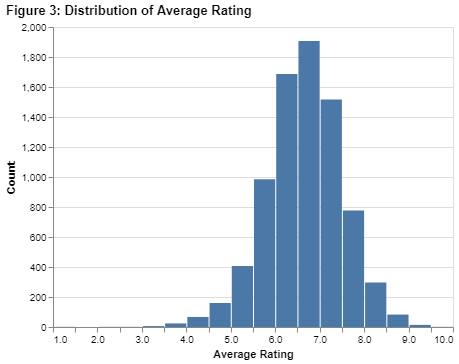

In [12]:
rating_plot = alt.Chart(
    train_df,
    title = alt.TitleParams(
        text = "Figure 3: Distribution of Average Rating",
        anchor = "start"
    )
).mark_bar().encode(
    x = alt.X("average", bin=alt.Bin(maxbins=30), title="Average Rating"),
    y = alt.Y("count()", title="Count")
)
rating_plot

It appears that most average ratings of board games are around 6-7, and the distribution resembles a bell shape. There are some ratings that are very high (9.57) and some very low (1.16), but values are somewhere in the midranges.

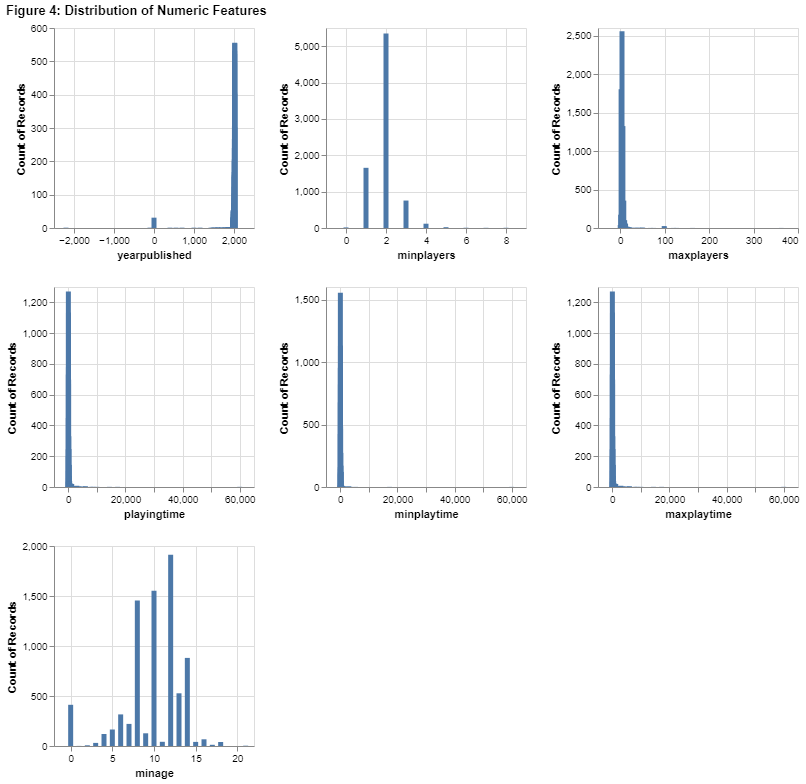

In [13]:
numeric_feats = train_df.select_dtypes(include="number").columns.tolist()[0:-1]
numeric_feats_bar_chart = alt.Chart(train_df).mark_bar().encode(
    x = alt.X(alt.repeat(), type="quantitative"),
    y = "count()"
).properties(
    width=200,
    height=200
).repeat(
    numeric_feats,
    columns=3
)
numeric_feats_bar_chart.properties(title = "Figure 4: Distribution of Numeric Features")


Looking at the distribution of each numeric feature, we can see that most numeric features are heavily right skewed, such as with `maxplayers`, `playingtime`, `minplaytime`, and `maxplaytime`. This is mostly inline with expectations: most games are usually played with 2-8 players, and playing times usually range from 1-2 hours. The `yearpublished` feature seems to have some weird values that do not make sense, such as years in the negative range.

<br>

**Figure 5: Correlation matrix of numeric features and target.**

In [14]:
train_df.corr('spearman').style.background_gradient()

,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,average
yearpublished,1.000000,-0.214463,0.095033,-0.083538,-0.254329,-0.083538,0.089744,0.401794
minplayers,-0.214463,1.000000,0.256342,-0.108282,-0.022613,-0.108282,-0.080336,-0.249795
maxplayers,0.095033,0.256342,1.000000,-0.109388,-0.121420,-0.109388,-0.039706,-0.169240
playingtime,-0.083538,-0.108282,-0.109388,1.000000,0.890620,1.000000,0.481827,0.385520
minplaytime,-0.254329,-0.022613,-0.121420,0.890620,1.000000,0.890620,0.434641,0.270424
maxplaytime,-0.083538,-0.108282,-0.109388,1.000000,0.890620,1.000000,0.481827,0.385520
minage,0.089744,-0.080336,-0.039706,0.481827,0.434641,0.481827,1.000000,0.282423
average,0.401794,-0.249795,-0.169240,0.385520,0.270424,0.385520,0.282423,1.000000


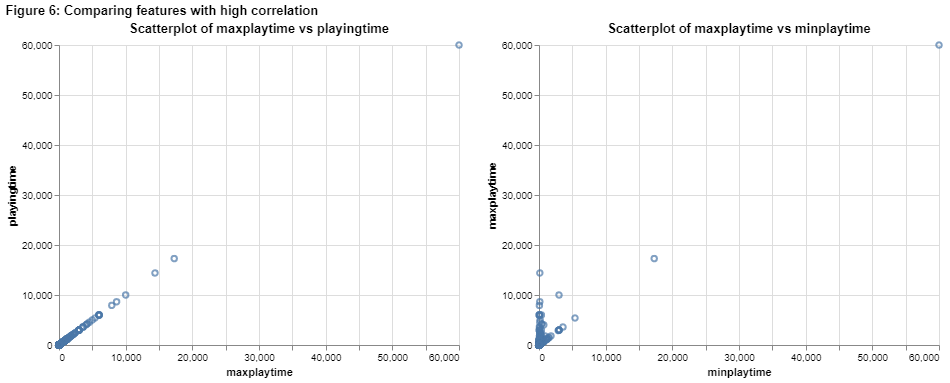

In [15]:
maxplaytime_vs_playingtime = alt.Chart(
    train_df,
    title = "Scatterplot of maxplaytime vs playingtime"
).mark_point().encode(
    x = alt.X("maxplaytime"),
    y = alt.Y("playingtime")
)
minplaytime_vs_maxplaytime = alt.Chart(
    train_df,
    title = "Scatterplot of maxplaytime vs minplaytime"
).mark_point().encode(
    x = alt.X("minplaytime"),
    y = alt.Y("maxplaytime")
)
(maxplaytime_vs_playingtime | minplaytime_vs_maxplaytime).properties(
    title = "Figure 6: Comparing features with high correlation"
)

From the correlation matrix and the plot, we can conclude that `maxplaytime` and `playingtime` have the same values for each row, hence having perfect correlation. This suggests that we can drop the `playingtime` column and it will not affect our model. It appears that `minplaytime` and `maxplaytime` have a positive relationship, although there are still values with a short `minplaytime` and large `maxplaytime`.

In [16]:
# IN CASE WE WANNA DO MORE EDA
eda_train = train_df

def binarize_rating(row):
    if row["average"] > 6.5:
        rating = "high"
    else:
        rating = "low"
    return rating
eda_train["rating"] = eda_train.apply(binarize_rating, axis=1)
eda_train

,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgameartist,boardgamepublisher,average,rating
1419,"Under a blazing sun in 4th century BCE, trader...",2019,2,4,30,20,30,8,['Dice'],"['Dice Rolling', 'Paper-and-Pencil']","['Ancient: Corinth', 'Animals: Camels', 'Anima...",['Sébastien Pauchon'],"['Julio Cesar', 'Cyrille Daujean']","['Days of Wonder', 'Happy Baobab']",6.77,high
1734,Wits &amp; Wagers Family is the family version...,2010,3,10,20,20,20,8,"[""Children's Game"", 'Educational', 'Party Game...","['Betting and Bluffing', 'Paper-and-Pencil']",['Components: Dry Erase Markers / Dry Erase Su...,['Dominic Crapuchettes'],"['Ali Douglass', 'Shawn Wilson (I)']","['Egmont Polska', 'Jumbo', 'Mandoo Games', 'No...",6.93,high
5041,In City Council each player takes the role of ...,2013,2,5,60,60,60,12,"['City Building', 'Negotiation', 'Political']","['Tile Placement', 'Voting', 'Worker Placement']",['Crowdfunding: Kickstarter'],['Elad Goldsteen'],['Giota Vorgia'],['Golden Egg Games'],6.11,low
15192,Description from the publisher:&#10;&#10;Ubong...,2015,1,4,25,25,25,8,NaN,['Pattern Building'],"['Game: Ubongo', 'Movies: Star Wars']",['Grzegorz Rejchtman'],"['Nicolas Neubauer', 'Sensit Communication GmbH']",['KOSMOS'],6.37,low
18250,Korea: Fire and Ice is the first game in a new...,2018,1,4,600,180,600,12,"['Korean War', 'Modern Warfare', 'Wargame']","['Chit-Pull System', 'Dice Rolling', 'Grid Mov...","['Country: Korea', 'Series: Operational Scale ...",['Adam Starkweather'],['Ilya Kudriashov'],['Compass Games'],7.26,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18679,"... Because of the storm, your farm and other ...",2019,3,7,30,15,30,8,"['Animals', 'Card Game', 'Party Game']",['Take That'],"['Animals: Chickens', 'Organizations: Board Ga...",['Sergio Ortiz'],['Enrique Guillamón'],['Venatus Ediciones'],7.48,high
6411,Candy Chaser is a bluffing game in which the p...,2013,2,4,10,10,10,10,['Bluffing'],"['Dice Rolling', 'Player Elimination']","['Series: Mini Games (IELLO)', 'Theme: Food / ...",['Masao Suganuma'],"['Lorène Barioz', 'Noboru Hotta']","['Grounding', 'IELLO']",5.91,low
6728,This CCG plays more like a board game than a c...,1995,2,4,45,45,45,12,"['Card Game', 'Collectible Components', 'Fanta...",['Secret Unit Deployment'],['Collectible: Collectible Card Games'],"['Keith Parkinson', 'Luke Peterschmidt']","['Christos Achilleos', 'Den Beauvais', 'Gerald...",['FPG'],6.39,low
900,American baseball was on its last legs as a sp...,2015,1,4,45,45,45,9,"['Card Game', 'Science Fiction', 'Sports']","['Card Drafting', 'Deck, Bag, and Pool Buildin...","['Players: Games with Solitaire Rules', 'Sport...",['Mike Fitzgerald'],"['William Bricker', 'Franz Vohwinkel']",['Eagle-Gryphon Games'],7.54,high
